In [2]:
import sys
sys.path.append('/nfs/homedirs/giri/masterthesis')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from robust_priornet.utils.visualizer import plot_adv_samples, plot_all_pr_curves, plot_all_roc_curves, plot_adv_samples_ood
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.eval.model_prediction_eval import ClassifierPredictionEvaluator
from robust_priornet.attack_priornet import plot_ood_attack_success

In [4]:
model_dir="runtime-model-vgg6-50epochs"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"
ood_dataset="SVHN"

### Utils

In [5]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [6]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Eval task on train set (only 5000 images)

### OOD-detect task

Positive sample (label=1) - out domain sample

Negative sample (label=0) - in domain sample

In [8]:
out_dir=model_dir+"/ood-eval-train-svhn"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --train_dataset --dataset_size_limit 5000 --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --train_dataset --dataset_size_limit 5000 --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/ood-eval-train-svhn ./runtime-data MNIST SVHN


In [8]:
os.system(cmd)

0

### Misclassify-detect task

Positive sample (label=1) - misclassified sample i.e predicted_label != truth_label

Negative sample (label=0) - correctly classified sample

In [9]:
out_dir=model_dir+"/eval-train"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task misclassification_detect --train_dataset --dataset_size_limit 5000 --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task misclassification_detect --train_dataset --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/eval-train ./runtime-data MNIST OMNIGLOT


In [10]:
os.system(cmd)

0

## Attack in-domain and eval ood-detect task on train set (same 5000 images)
### In-domain samples are transformed to adversarial samples, out domain samples are also transformed to adversarial samples  - then evaluated for ood-detect task

OOD dataset used is different from the one the model was trained on. Model was trained on OMNIGLOT, we attack SVHN dataset and provide it as out distribution samples.

### Diff entropy attack - MNIST + SVHN

In [9]:
out_dir=model_dir+"/attack-fgsm-train-ood-svhn"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset SVHN --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-train-ood-svhn


In [10]:
os.system(cmd)

0

#### Attack's epsilon curve - diff entropy

In [7]:
thresholds = [-18.52049,-14.93081,-13.73132,-13.20055,-13.10584,-13.00481,-12.92809,-12.88405,-12.83937,-12.83091]

In [10]:
result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -18.52049
tn: 3621, fp: 1379, fn: 500, tp: 4500, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -14.93081
tn: 3272, fp: 1728, fn: 1001, tp: 3999, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -13.73132
tn: 3452, fp: 1548, fn: 1001, tp: 3999, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -13.20055
tn: 3959, fp: 1041, fn: 1001, tp: 3999, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -13.10584
tn: 3767, fp: 1233, fn: 749, tp: 4251, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -13.00481
tn: 3746, fp: 1254, fn: 748, tp: 4252, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -12.92809
tn: 3750, fp: 1250, fn: 869, tp: 4131, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -12.88405
tn: 3576, fp: 1424, fn: 1001, tp: 3999, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -12.83937
tn: 3500, fp: 1500, fn: 1316, tp: 3684, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -12.83091
tn: 28

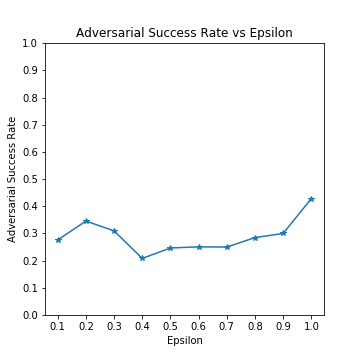

In [11]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

# in accordance with

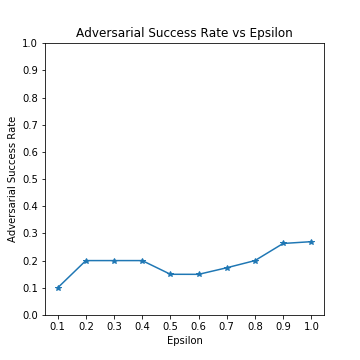

In [12]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))

In [13]:
# same measure before attack (using threshold value based on no attack eval, tpr=1.0, fpr=0.001)
id_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train-svhn', 'id_differential_entropy.txt'))
ood_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train-svhn', 'ood_differential_entropy.txt'))
y_preds = np.concatenate((id_dist_un, ood_dist_un), axis=0)
y_true = np.concatenate((np.zeros_like(id_dist_un), np.ones_like(ood_dist_un)), axis=0)
tn, fp, fn, tp = ClassifierPredictionEvaluator.compute_confusion_matrix_entries(y_preds, y_true, -19.03791)
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, total: {len(y_true)}")

tn: 4991, fp: 9, fn: 1, tp: 4999, total: 10000


In [8]:
# some adversarial samples
org_eval_dir = os.path.join(model_dir, 'ood-eval-train-svhn')
plot_adv_samples_ood(org_eval_dir, out_dir, 0.5, thresholds[4], UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, limit=100)

Cross check: fp: 1233
Cross check: fn: 749


1982

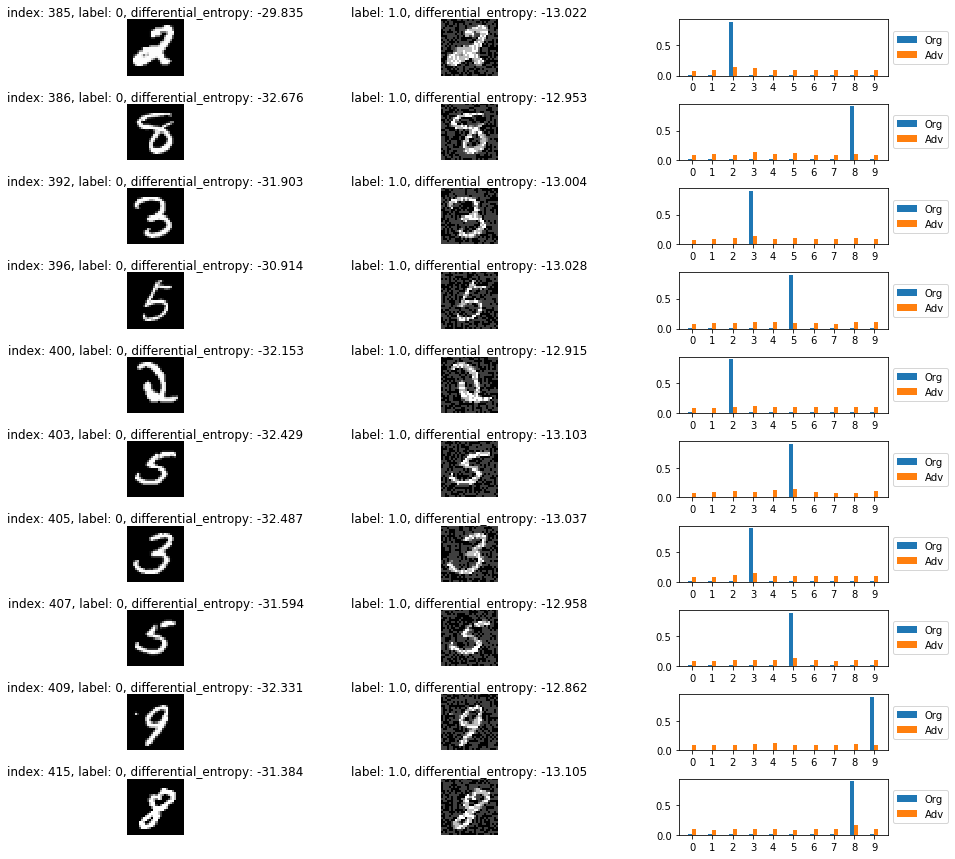

In [10]:
# in domain --> out domain (adversarial success for attacking in domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis', 'in-out', 'result_vis_100.png')))

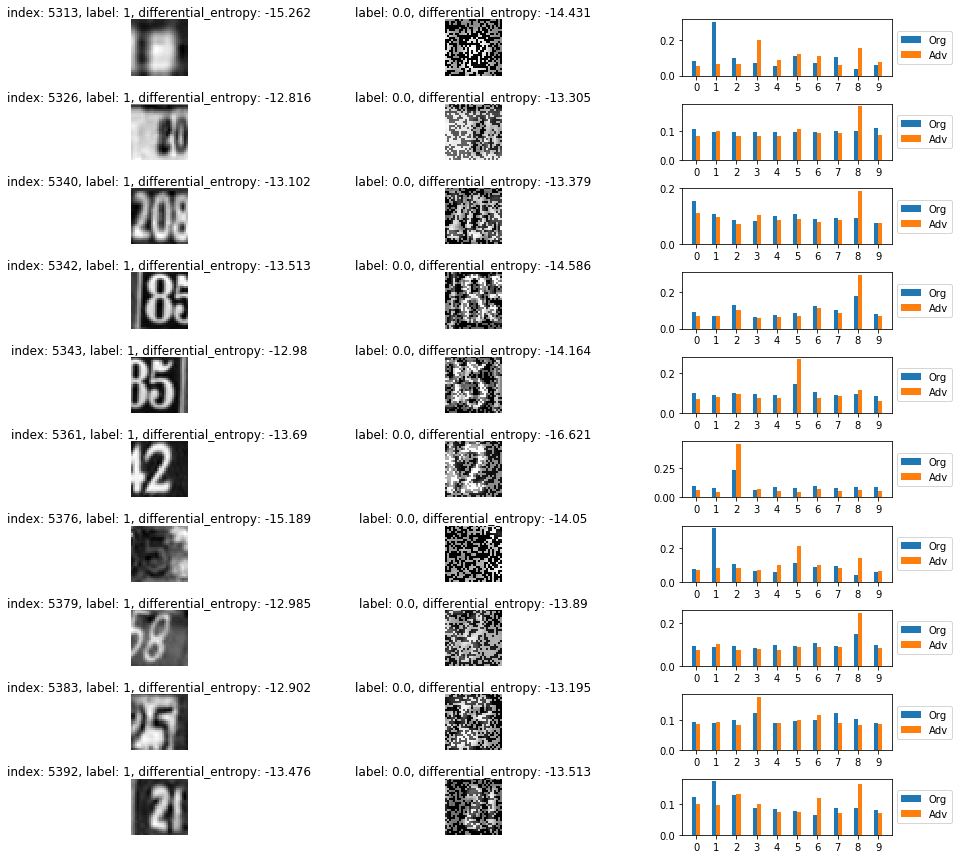

In [11]:
# out domain --> in domain (adversarial success for attacking out domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis', 'out-in', 'result_vis_60.png')))

# note the overall reduction in

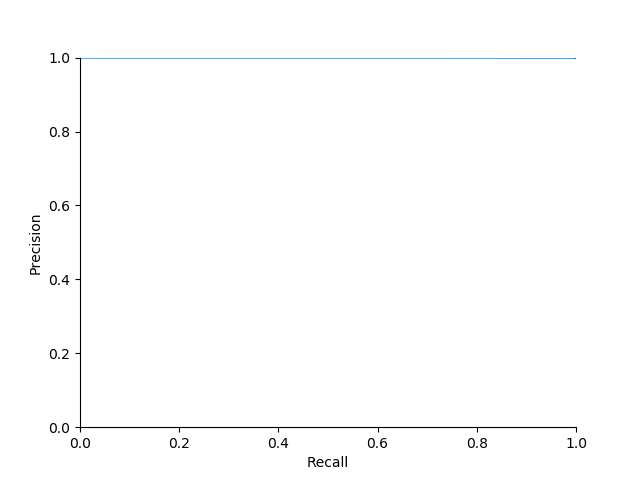

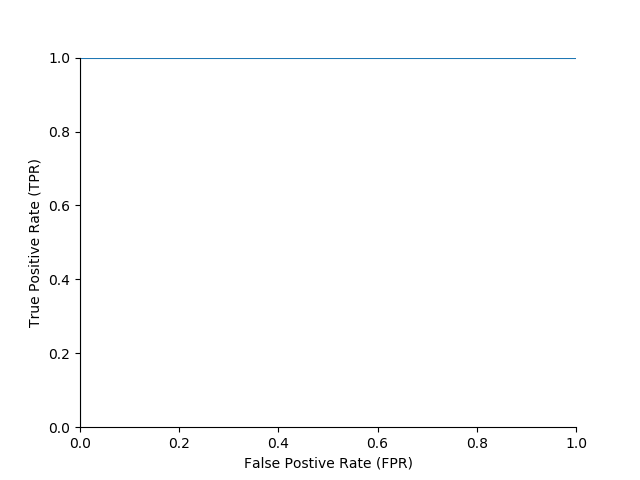

In [14]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

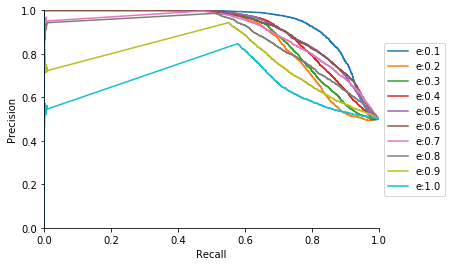

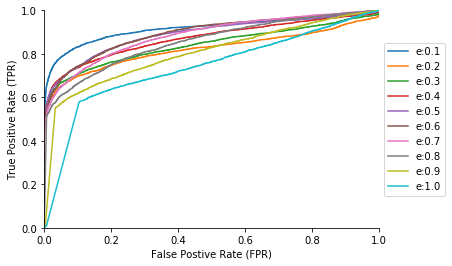

In [12]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-svhn")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

#### Attack's epsilon curve - distributional uncertainty - TODO: Update thresholds for SVHN

In [7]:
thresholds = [0.3764342] * len(epsilon_list)

result_dir = os.path.join(out_dir, 'ood-success-duncertainty')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: 0.3764342
tn: 4979, fp: 21, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: 0.3764342
tn: 4924, fp: 76, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: 0.3764342
tn: 4680, fp: 320, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: 0.3764342
tn: 4354, fp: 646, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: 0.3764342
tn: 3882, fp: 1118, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: 0.3764342
tn: 3176, fp: 1824, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: 0.3764342
tn: 2901, fp: 2099, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: 0.3764342
tn: 3151, fp: 1849, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: 0.3764342
tn: 3438, fp: 1562, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: 0.3764342
tn: 3560, fp: 1440, fn: 0, tp: 5000

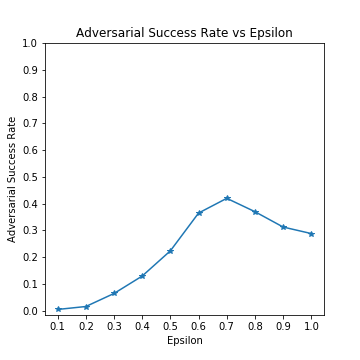

In [18]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-duncertainty', 'epsilon-curve_id.png')))

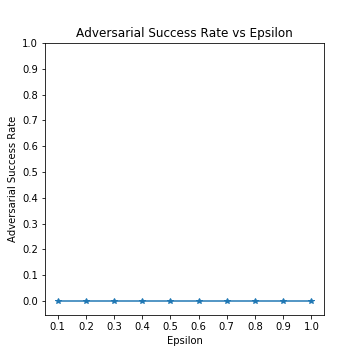

In [19]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-duncertainty', 'epsilon-curve_ood.png')))

In [20]:
# same measure before attack (using same threshold value)
id_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train-svhn', 'id_distributional_uncertainty.txt'))
ood_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train-svhn', 'ood_distributional_uncertainty.txt'))
y_preds = np.concatenate((id_dist_un, ood_dist_un), axis=0)
y_true = np.concatenate((np.zeros_like(id_dist_un), np.ones_like(ood_dist_un)), axis=0)
tn, fp, fn, tp = ClassifierPredictionEvaluator.compute_confusion_matrix_entries(y_preds, y_true, 0.3764342)
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, total: {len(y_true)}")

tn: 4995, fp: 5, fn: 0, tp: 5000, total: 10000


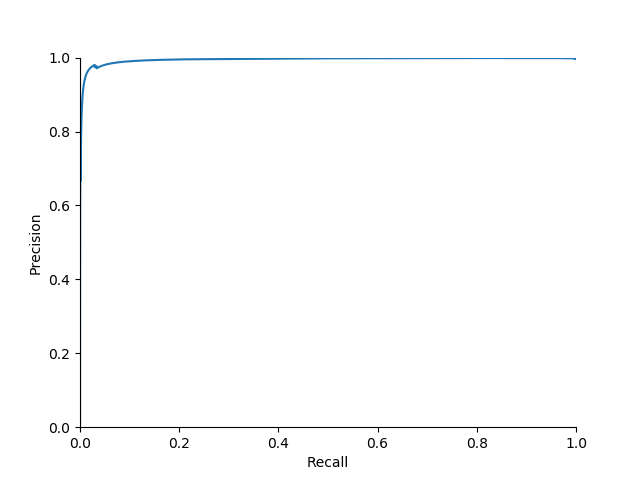

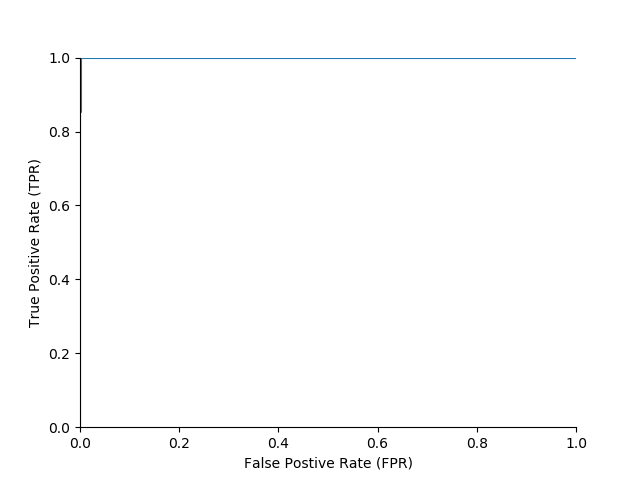

In [13]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY)

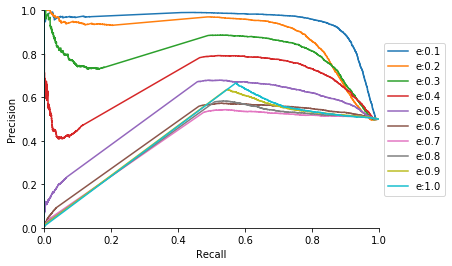

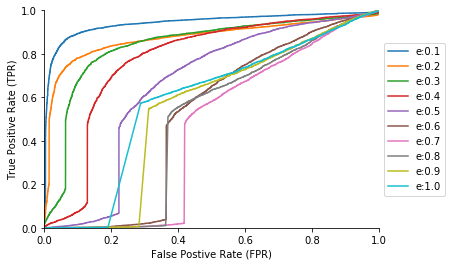

In [14]:
# model under attack (up to date for SVHN)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-svhn")
measure = UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

### Confidence attack

In [12]:
out_dir=model_dir+"/attack-fgsm-train-ood-conf-svhn"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --train_dataset --ood_eval --ood_dataset {ood_dataset} --dataset_size_limit 5000 --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --train_dataset --ood_eval --ood_dataset SVHN --dataset_size_limit 5000 --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-train-ood-conf-svhn


In [13]:
os.system(cmd)

0

#### Attack's epsilon curve - confidence - TODO: update thersholds for SVHN

In [12]:
# threshold values are negative for confidence measure, as we want confidence value 
# for in domain (label=0) sample to be lower than out domain (label=1) sample.
# But in reality confidence for label=0 is higher, so we negate
thresholds = [-0.1011998355388641357] * 4
thresholds += [-0.1002346575260162354] * 6

result_dir = os.path.join(out_dir, 'ood-success-confidence')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.CONFIDENCE, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -0.10119983553886414
tn: 5000, fp: 0, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -0.10119983553886414
tn: 5000, fp: 0, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -0.10119983553886414
tn: 5000, fp: 0, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -0.10119983553886414
tn: 5000, fp: 0, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -0.10023465752601624
tn: 5000, fp: 0, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -0.10023465752601624
tn: 4999, fp: 1, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -0.10023465752601624
tn: 4994, fp: 6, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -0.10023465752601624
tn: 4967, fp: 33, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -0.10023465752601624
tn: 4849, fp: 151, fn: 1, tp: 4999, total_id: 5000, total

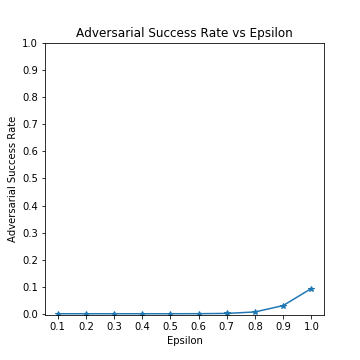

In [13]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-confidence', 'epsilon-curve_id.png')))

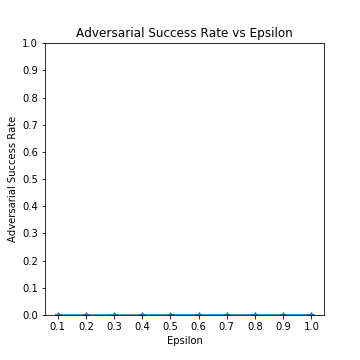

In [14]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-confidence', 'epsilon-curve_ood.png')))

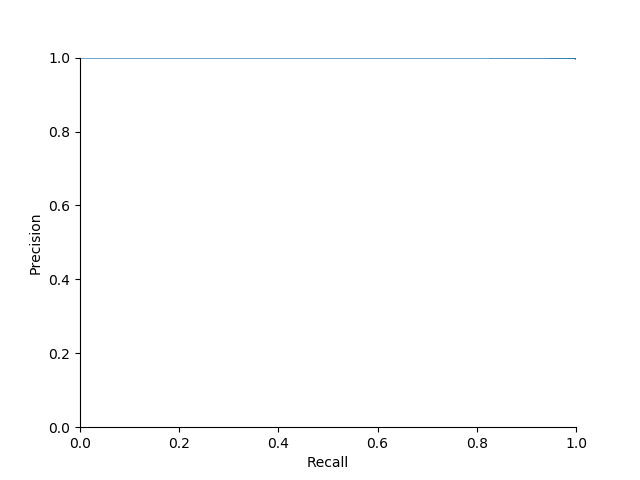

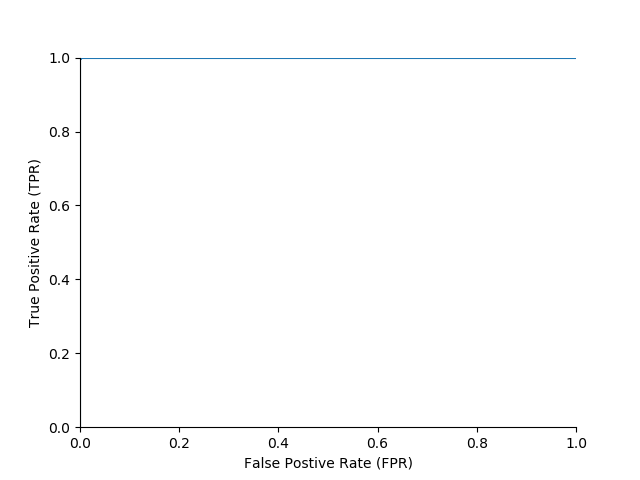

In [14]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.CONFIDENCE)

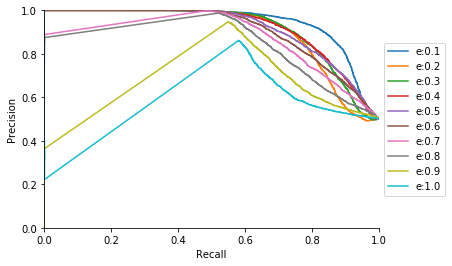

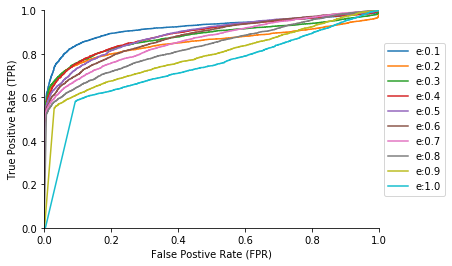

In [15]:
# model under attack - confidence (up to date)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf-svhn")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

#### Attack's epsilon curve - distributional uncertainty - TODO: Update thresholds for SVHN

In [15]:
thresholds = [0.3764342069625854492] * len(epsilon_list)

result_dir = os.path.join(out_dir, 'ood-success-duncertainty')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: 0.37643420696258545
tn: 4979, fp: 21, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: 0.37643420696258545
tn: 4901, fp: 99, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: 0.37643420696258545
tn: 4657, fp: 343, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: 0.37643420696258545
tn: 4313, fp: 687, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: 0.37643420696258545
tn: 3839, fp: 1161, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: 0.37643420696258545
tn: 3142, fp: 1858, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: 0.37643420696258545
tn: 2897, fp: 2103, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: 0.37643420696258545
tn: 3145, fp: 1855, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: 0.37643420696258545
tn: 3414, fp: 1586, fn: 0, tp: 5000, total_id: 50

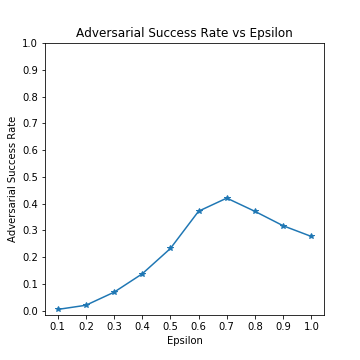

In [16]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-duncertainty', 'epsilon-curve_id.png')))

# NOTE: this shows that diff_uncertainty measure gets affected if attack criteria was either diff_entropy or confidence

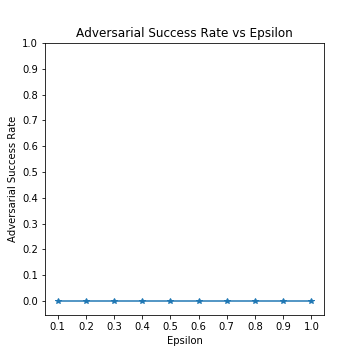

In [17]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-duncertainty', 'epsilon-curve_ood.png')))

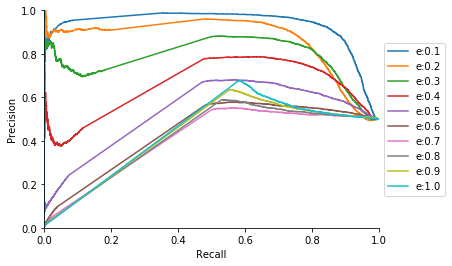

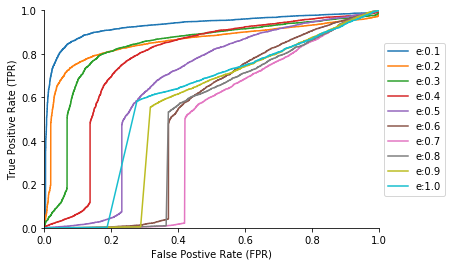

In [13]:
# model under attack (up to date)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf-svhn")
measure = UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

#### Attack's epsilon curve - differential entropy

In [19]:
thresholds = [-12.80262] * 7
thresholds += [-12.8021] * 3

result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -12.80262
tn: 5000, fp: 0, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -12.80262
tn: 5000, fp: 0, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -12.80262
tn: 5000, fp: 0, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -12.80262
tn: 5000, fp: 0, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -12.80262
tn: 4999, fp: 1, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -12.80262
tn: 4997, fp: 3, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -12.80262
tn: 4989, fp: 11, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -12.8021
tn: 4964, fp: 36, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -12.8021
tn: 4835, fp: 165, fn: 1, tp: 4999, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -12.8021
tn: 4508, fp: 492, fn: 1, tp: 4999, total_id: 5000, tot

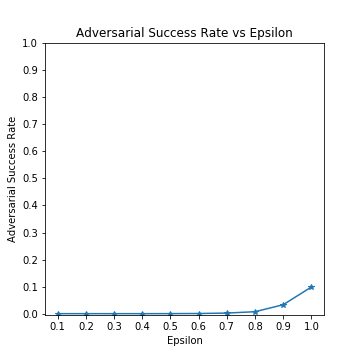

In [20]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

# NOTE: This shows diff_entropy is still robust to confidence attack

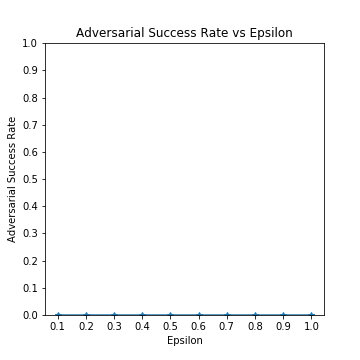

In [21]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))

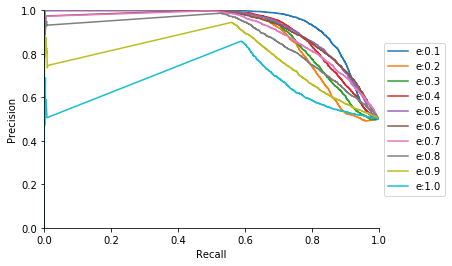

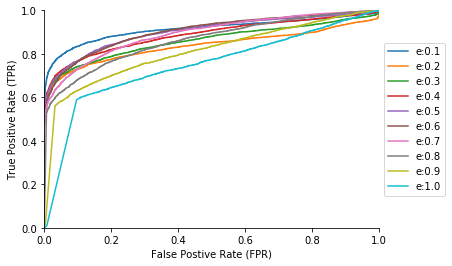

In [14]:
# model under attack - differential entropy
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf-svhn")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))